Dad Joke Filter
Goal: Make a filter for my dad that can predict if a joke of his is funny
This Notebook: Filter jokes based off of his type, remove mispellings, and create a binary classifcation datset containing funny and not funny jokes

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.html.use_mathjax', False)
pd.options.display.max_colwidth = None

# custom functions
from utils import *
from jupyterthemes import jtplot
jtplot.style()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Read-in and explore the dataset

In [2]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [3]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i/i_am_soooo_glad_im_not_circumcised/,self.jokes,NaN,My corona is covered with foreskin so it is not exposed to viruses.,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for recording your bowel movements?,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj/what_is_the_difference_between_my_wife_and_my/,self.jokes,NaN,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",What is the difference between my wife and my vacuum?,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh/my_last_joke_for_now/,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg/the_nintendo_64_turns_18_this_week/,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [4]:
df.shape

(1000000, 12)

In [5]:
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [6]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


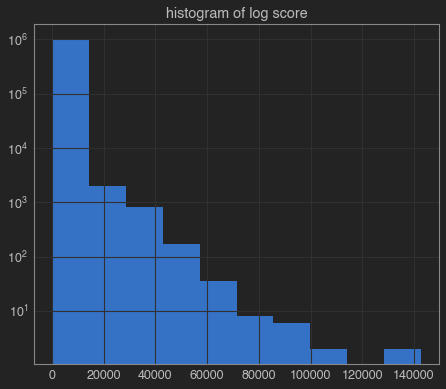

In [7]:
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [8]:
# define some parameters 
CLASS_SIZE = 50000
TRAIN_SIZE = 0.95
MIN_UPVOTES = 50
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 200
SELFTEXT_MAX_LEN = 200

In [9]:
# boolean masks
# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.lower().str.contains(r"[^a-z\s]removed[^a-z\s]", regex=True)) | (df['title'].str.lower().str.contains(r"[^a-z\s]removed[^a-z\s]", regex=True)) 

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.lower().str.contains(r"[^a-z\s]deleted[^a-z\s]", regex=True)) | (df['title'].str.lower().str.contains(r"[^a-z\s]deleted[^a-z\s]", regex=True)) 

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [10]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565332, 12)

In [11]:
# what are nans?
df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10) 

,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [12]:
df_cleaned = df_cleaned[~is_null]

In [13]:
# find edits:
PATTERN = r"[^a-zA-Z](e|E)(d|D)(i|I)(t|T)\W.+"

# clean posts to change this ... 
edits_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[edits_idx][['title', 'selftext']].head()

,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit.\n\nShe didn't even know that rain was something you need to come in to from out of.\n\n&amp;#x200B;\n\nEDIT: IOW she didn't like sentences that ended in five prepositions.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?""\n\n\n\n\n\n\nThe other parrot replied ""Oh my, a talking bird.""\n\n\n\n\n*edit: spelling*"
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. \n\nI say pizz and past, like a _real_ American.\n\n\n\nEdit: wording"
1096,A man with a COVID-19 walks into the bar,...and is told to leave. \n\n[edit]: I'm gonna go offline for 14 days for hating myself.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads.\n\nOwned.\n\nEdit: punch line


In [14]:
# remove user edits added after user posted content, remove newline characters
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x:re.sub(PATTERN, " ", x.replace("\n", " ")))

# into this ...
df_cleaned[['title', 'selftext']].loc[edits_idx].head()

,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of. &amp;#x200B;
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."""
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American."
1096,A man with a COVID-19 walks into the bar,...and is told to leave.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned.


In [15]:
# removing html character references and user comments (put in by [...] or (...))
PATTERN = r"(&\S+;)|(\(.*?\))|(\[.*?\])"

# get examples of instances containing pattern
html_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[html_idx][['title', 'selftext']].head()

,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. &amp;#x200B; ""Many moons pass, and chief Walking Horse no go number two."" He complains. &amp;#x200B; The doctor reaches into his cabinet and fishes out a mild laxative. &amp;#x200B; ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" &amp;#x200B; The chief took the little bottle, and left back to his village. &amp;#x200B; Two days later, ask the Doctor requested, he's back. &amp;#x200B; ""Chief Walking Horse, have you moved yet?"" &amp;#x200B; The chief slowly shakes his head no. &amp;#x200B; ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" &amp;#x200B; The chief nods his head yes, and leaves to return to his village. &amp;#x200B; This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. &amp;#x200B; A few days later, while visiting a close by settlement, the Doctor sees the Chief. &amp;#x200B; ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" &amp;#x200B; The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage: (Read from bottom to top)
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches (so he gets $7.5M). Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: [tearing up] ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: [angry] ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""


In [16]:
# see changes

df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, " ", x))
df_cleaned.loc[html_idx][['title', 'selftext']].head()

,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. ""Many moons pass, and chief Walking Horse no go number two."" He complains. The doctor reaches into his cabinet and fishes out a mild laxative. ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" The chief took the little bottle, and left back to his village. Two days later, ask the Doctor requested, he's back. ""Chief Walking Horse, have you moved yet?"" The chief slowly shakes his head no. ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" The chief nods his head yes, and leaves to return to his village. This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. A few days later, while visiting a close by settlement, the Doctor sees the Chief. ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage:
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches . Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""


In [17]:
# emojis
PATTERN = r"[\U00002122-\U0010ffff]|[\u00A9-\u00AE]"

# generate instances of patterns for showing
emoji_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[emoji_idx][['title', 'selftext']].head()

,title,selftext
1175,British people are like: “I’m Bri ish”,...and here’s the t☕️
1265,This social distancing is going too far.,I just went to make a cake and the first line on the packet said separate 2 eggs 🥚 🥚
2412,"A woman walks into a doctor's office and takes off her shirt and bra, revealing an H-shaped rash. ""Can you fix this rash?"" asked the woman.","""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Harvard graduate, he insists on wearing his Harvard shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an Y-shaped rash. ""Can you fix this rash?"" asked the woman. ""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Yale graduate, he insists on wearing his Yale shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an W-shaped rash. ""Can you fix this rash?"" asked the woman. ""Let me guess,"" said the doctor, ""your dating a Washington graduate?"" ""No, she's a Michigan graduate.""﻿"
4129,"So I said to my girl, it’s not that I’m always horny",It’s just that you’re always beautiful!🇨🇦
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away 😂😂😂 L😎L


*note that the selftext at id location 2412 does not show any emoji as identified by the pattern, but copying and pasting into a text editor shows a hidden emoji unicode character tailing the string:*

![example of hidden char](./images/jokes/hidden_utf_char.png)

In [18]:
# examine changes
df_cleaned[['title', 'selftext']] = df_cleaned[['title','selftext']].applymap(lambda x: re.sub(PATTERN, "", x))
df_cleaned[['title', 'selftext']].loc[emoji_idx].head()

,title,selftext
1175,British people are like: “I’m Bri ish”,...and here’s the t
1265,This social distancing is going too far.,I just went to make a cake and the first line on the packet said separate 2 eggs
2412,"A woman walks into a doctor's office and takes off her shirt and bra, revealing an H-shaped rash. ""Can you fix this rash?"" asked the woman.","""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Harvard graduate, he insists on wearing his Harvard shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an Y-shaped rash. ""Can you fix this rash?"" asked the woman. ""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Yale graduate, he insists on wearing his Yale shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an W-shaped rash. ""Can you fix this rash?"" asked the woman. ""Let me guess,"" said the doctor, ""your dating a Washington graduate?"" ""No, she's a Michigan graduate."""
4129,"So I said to my girl, it’s not that I’m always horny",It’s just that you’re always beautiful!
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away LL


In [19]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['selftext'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 1) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 1) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

360578 samples match


### Filtering for my dad

In [20]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(\sclick\s)|(sub)?(reddit)|\S(vote)s?|(\sop\s)|https?\S+|([a-z]?(re)?post(?=(ed)|[^a-z]|$))|_"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
df_cleaned[is_meta].sample(10)[['title', 'selftext', 'score']]

,title,selftext,score
628779,There is only one JOKE in this post,JOKE,0
827346,Why does the Pope keep his underwear on while bathing?,"Because he doesn't like looking down on the unemployed. First to ever post this joke here, yay!",12
429382,"I'm trying to spread ""quotient"" awareness",Please upvote for divisibility.,6
592143,My girlfriend just broke up with me through reddit. Here's the last message she sent me,there doesn't seem to be anything here,33
610066,Why don't redditors use Facebook or Twitter?,They don't have followers or friends.,0
388886,"I made an Initial D joke on r/Jokes once, after an hour..",DEJA VU,1
985278,What do you call a loonie answering questions on reddit?,"DollarAMA. *Only Canadians will get it, sorry.",0
705206,"If I win tonight's Powerball, I'm sharing with everyone on Reddit.",I'm not sharing the money. I'll just let you know I won.,1015
430530,"For every upvote this gets, my girlfriend and I will try one thrust of anal sex.",Please don't upvote. Her strap-on is huge.,32259
925543,What does a Astronaut that likes to play Basketball eat for Breakfast,Space Jam I hope this hasn't been posted yet,2


In [21]:
df_cleaned = df_cleaned[~is_meta]

In [22]:
# offensive jokes
# boolean mask that identifies strings with offensive content
PATTERN = r"(?<![a-z])(nsfw).?|(\swhore\w?)|(\shookers?\s)|(\sorgasm\w?)|(\ssex\s)|(\sdicks?\s)|(\sboobs?\s)|(\spenis\s)|(\svaginas?\s)|(\snipples?\s)|(\srape\w?)|(\sanal\s)|(\sniggers?\s)|(\stits?\s)|(\sblack people\s)|(\sblack m(a|e)n\s)|(cocks?\s)|(\spussy\s)|(\scunt\s)|(\sgay\s)|(\sshit)|(\sfuck)|(\sjew)"
is_offensive = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)

# # uncomment below to check this NSFW
# df_cleaned[is_offensive & is_short].sample(30)[['title', 'selftext', 'score']]

In [23]:
df_cleaned = df_cleaned[~is_offensive]

In [24]:
# Filter entries that are short, but meet other necessary criteria again
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 2) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

327209 samples match


In [25]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

***** calculating *****
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 50000
current size 44558


### Make the positive and negative class labels and concatenate the dataframe

          count         mean          std   min   25%    50%    75%       max
target                                                                       
False   44558.0     0.000000     0.000000   0.0   0.0    0.0    0.0       0.0
True    44558.0  1324.996656  4809.116319  51.0  80.0  154.0  425.0  136359.0
Saving figure class distribution after cleaning


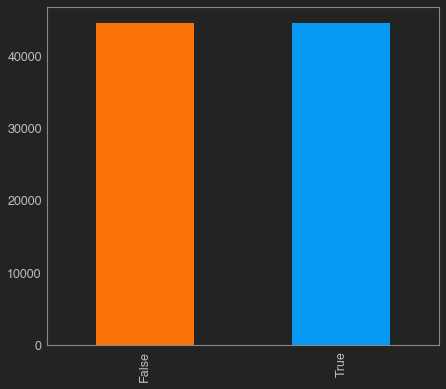

In [26]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
print(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

### Split into train / test data

In [27]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(84660, 15) (4456, 15)


## Explore the Curated DataFrame

In [28]:
# some useful boolean masks
is_funny = train['target'] == True

In [29]:
# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
2994,"After the COVID-19 pandemic winds down, we should honor truck drivers with a national holiday on October 4th.","A big 10-4, if you will.",20474
654763,My wife gave me some bad news today,"""But,"" she said, ""I bought your favorite soy sauce to help cheer you up."" ""Great,"" I said. ""Just Kikkoman when he's down, huh?"" I'm very soy for that pun. I'll just wok away now.",3520
706756,I am thinking about pursuing a job as a crowd estimator,I wonder how many people are in that field,1303
451672,When does a dad joke become a dad joke?,When it's fully groan.,8016
796510,This fibonacci joke,is as bad as the last two you heard combined,2610
234763,"Just got back from a job interview, where I was asked if can perform under pressure.",I said I wasn't too sure about that but I do a wicked Bohemian Rhapsody.,2092
761748,Where was the first chicken fried?,In Greece.,956
454167,I liked the Harry Potter books and movies but...,I just feel like the character Nearly Headless Nick was a bit poorly executed.,1766
4387,I give to you a joke I made up when I was seven: Why did the computer crash?,Because it had a bad driver! *drops mic*,7005
378130,Welcome to Masturbation Addicts Anonymous!,"I see everyone came today, which is disappointing.",1495


In [30]:
# examples of not funny jokes
train[train['score'] == 0][['title', 'selftext']].sample(10)

,title,selftext
924829,Whats the difference between a lesbian and a wheat-thin?,"Ones a snack cracker, the other is a crack snacker."
829422,Sometimes I look at myself in the mirror and get depressed over how fat I look...,I really shouldn't have bought a funhouse mirror.
421306,What do you get when you mix a Chihuahua with Shih Tzu?,A Diarrhea
988811,Before it was cool,"Once a hipster went out without a jacket in the winter and started to feel cold.. And a person asked him why he didn't get a jacket the hipster replied ""I went out before it was cool"""
72896,What do you call a turkey that was left out at winter,A cold turkey
815317,I read a book on anti-gravity...,I couldn't put it down.
506106,What kind of moisturizer do skunks use?,Stink Balm
417535,A black is interviewed as a witness.,"""Please describe the offender."" ""He was black."" ""Can you give more details please?"" ""I'm sorry officer, you know we blacks all look alike."""
850475,What do you tell your SO when they won't swallow?,You can't spell nutrition without NUT
809176,"Hey baby, are you an insect?","""'Cause you got a fly ass!!"""


Saving figure density plot of log title length


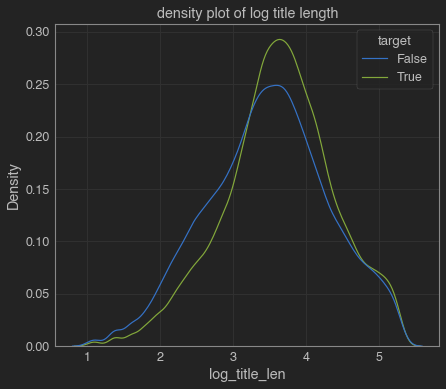

Saving figure density plot of log selftext length


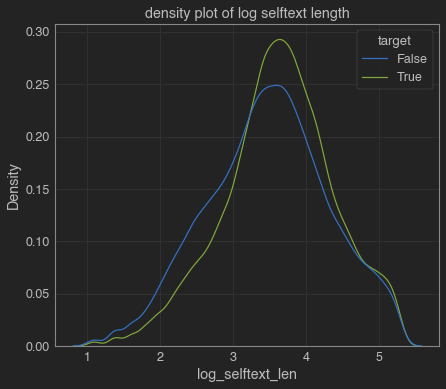

In [31]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()


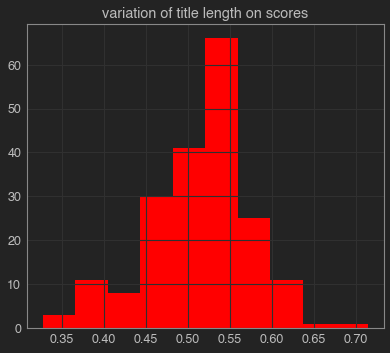

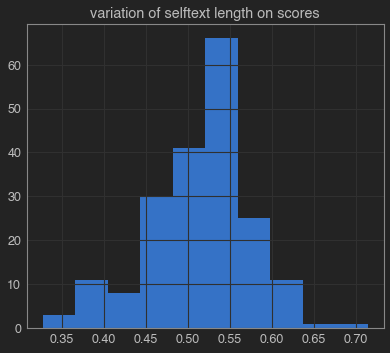

In [32]:
train.groupby(['title_len']).mean()['target'].hist(color='red')
plt.title('variation of title length on scores')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores')
plt.show()

### Examine Time Series Data

In [33]:
# making unix created_times into readable timestamps
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].set_index('created_at', drop=True).sort_index()
df_not_funny = train[~is_funny].set_index('created_at', drop=True).sort_index()

Saving figure submissions over time


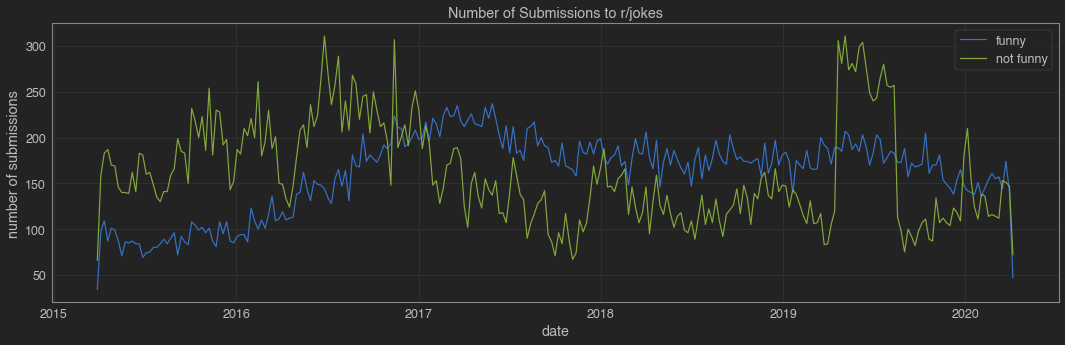

In [34]:
# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

Saving figure average submission per hour


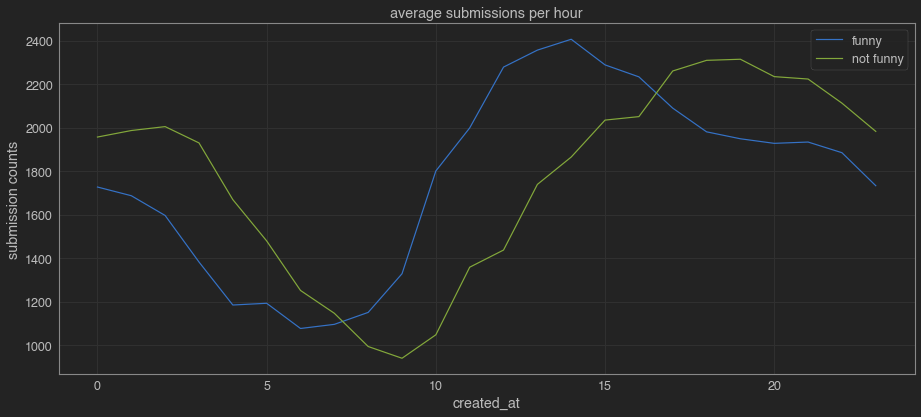

In [35]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

<AxesSubplot:xlabel='created_at', ylabel='type'>

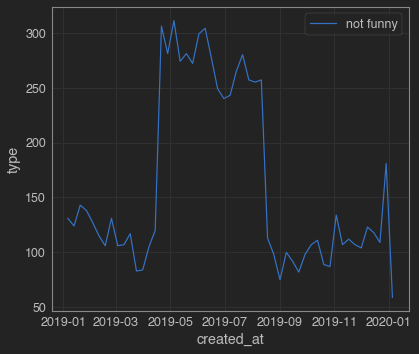

In [36]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')

In [37]:
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date.date()), str(end_date.date())
print(f'dates of anomaly: {start_date_not_funny_event} - {end_date_not_funny_event}')

dates of anomaly: 2019-04-07 - 2019-09-01


In [38]:
# save to pickle
pd.to_pickle(train, "./data/train.pkl")
pd.to_pickle(test, "./data/test.pkl")